In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
sys.path.append('/app/notebooks/hdfs')
from utils import *

#### Charger données prétraitées

In [2]:
df = load_data()
event_cols = get_event_columns(df)

print(f"Shape: {df.shape}")
print(df.head())

Shape: (575061, 32)
                    BlockId    Label  Type  E1  E2   E3  E4  E5  E6  E7  ...  \
0  blk_-1608999687919862906  Success   NaN   0   0  203   0  10   7   0  ...   
1   blk_7503483334202473044  Success   NaN   0   2    1   0   3   0   0  ...   
2  blk_-3544583377289625738     Fail  21.0   0   0  203   0   3   0   0  ...   
3  blk_-9073992586687739851  Success   NaN   0   3    0   0   3   0   0  ...   
4   blk_7854771516489510256  Success   NaN   0   3    1  15   3   0   0  ...   

   E20  E21  E22  E23  E24  E25  E26  E27  E28  E29  
0    0   10    1   10    0    4   10    0    0    0  
1    0    3    1    3    0    0    3    0    0    0  
2    1    3    1    3    0    0    3    0    0    0  
3    0    3    1    3    0    0    3    0    0    0  
4    0    3    1    3    0    0    3    0    0    0  

[5 rows x 32 columns]


#### Exploration des donnees

In [3]:
# Affichez les types de données de toutes les colonnes 
print(df.info()) 

missing_counts = df.isnull().sum()
missing_percent = 100 * missing_counts / len(df) # Calcul du pourcentage

missing_df = pd.DataFrame({
    'Manquantes': missing_counts,
    'Pourcentage': missing_percent
})

# Afficher uniquement les colonnes qui ont des valeurs manquantes et trier par pourcentage
missing_to_show = missing_df[missing_df['Manquantes'] > 0].sort_values(
    by='Pourcentage', ascending=False
)
print(missing_to_show)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 32 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BlockId  575061 non-null  object 
 1   Label    575061 non-null  object 
 2   Type     16838 non-null   float64
 3   E1       575061 non-null  int64  
 4   E2       575061 non-null  int64  
 5   E3       575061 non-null  int64  
 6   E4       575061 non-null  int64  
 7   E5       575061 non-null  int64  
 8   E6       575061 non-null  int64  
 9   E7       575061 non-null  int64  
 10  E8       575061 non-null  int64  
 11  E9       575061 non-null  int64  
 12  E10      575061 non-null  int64  
 13  E11      575061 non-null  int64  
 14  E12      575061 non-null  int64  
 15  E13      575061 non-null  int64  
 16  E14      575061 non-null  int64  
 17  E15      575061 non-null  int64  
 18  E16      575061 non-null  int64  
 19  E17      575061 non-null  int64  
 20  E18      575061 non-null  

### Analyse de la distribution et de la relation des caractéristiques

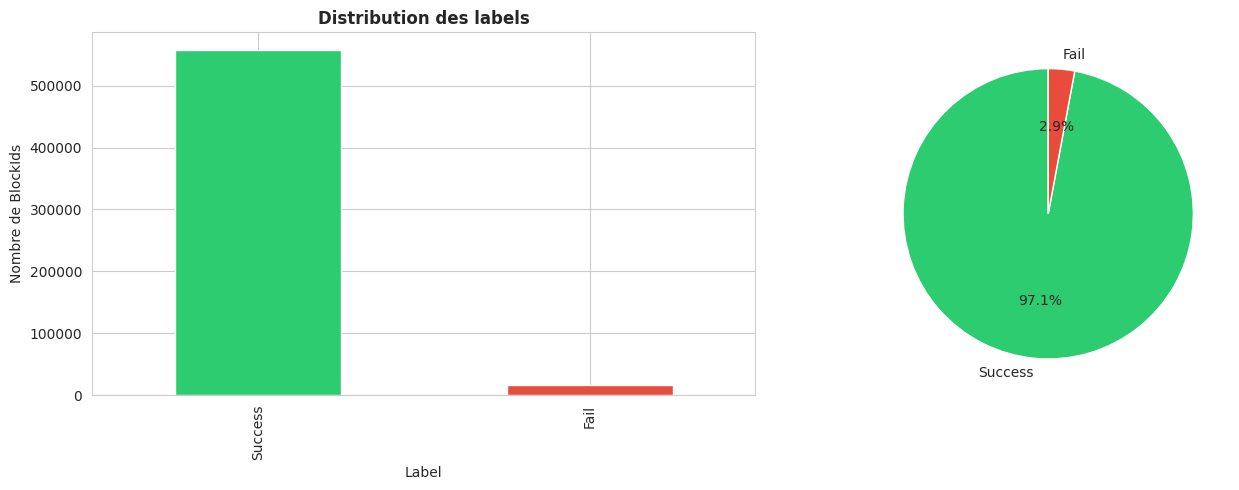

In [4]:
label_dist = df['Label'].value_counts()
ratio = label_dist.iloc[0] / label_dist.iloc[1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

label_dist.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title(f'Distribution des labels', fontweight='bold')
axes[0].set_ylabel('Nombre de BlockIds')

axes[1].pie(label_dist, labels=label_dist.index, autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


E5     1723232
E26    1719741
E11    1706679
E9     1706514
E21    1402047
E23    1396174
E22     575061
E3      428726
E4      356207
E2      120036
dtype: int64


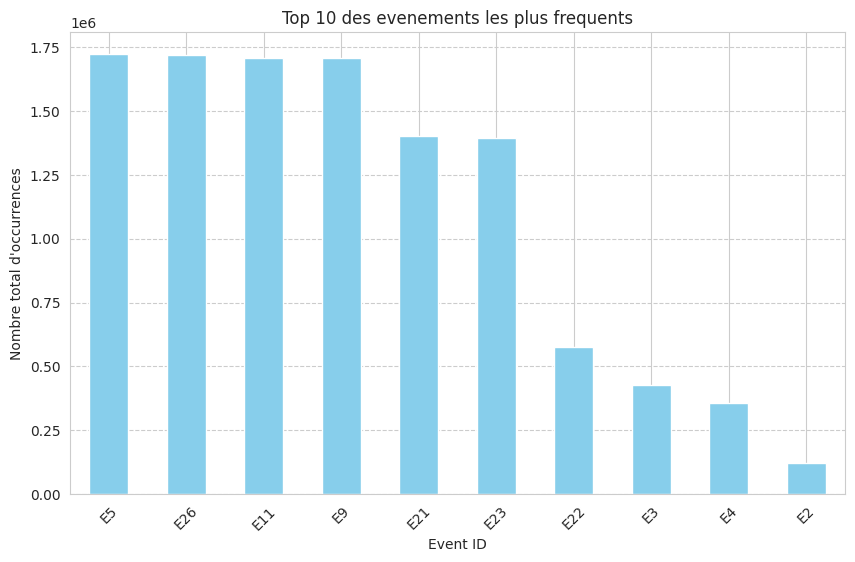


evenement a faible variance (15:
E22    0.000000
E24    0.000007
E19    0.000012
E17    0.000016
E1     0.000035
E29    0.000085
E12    0.000087
E8     0.000096
E15    0.000207
E10    0.000358
E14    0.000756
E27    0.001696
E28    0.002388
E7     0.006503
E13    0.007631
dtype: float64

### 3.evenement les plus rares
E12    34
E1     10
E17     9
E19     5
E24     4
dtype: int64


In [5]:
X = df.filter(regex='^E\d+$').fillna(0)
#  analyse de la frequence des événements ---
total_counts = X.sum().sort_values(ascending=False)
print(total_counts.head(10))

# Visualisation des fréquences
plt.figure(figsize=(10, 6))
total_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 des evenements les plus frequents')
plt.ylabel('Nombre total d\'occurrences')
plt.xlabel('Event ID')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


# Calculer la variance de chaque colonne
event_variance = X.var().sort_values(ascending=True)

low_variance_events = event_variance[event_variance < 0.01] # Seuil très bas

if not low_variance_events.empty:
    print(f"\nevenement a faible variance ({len(low_variance_events)}:")
    print(low_variance_events)


# --- 3. Analyse de la Rareté (Événements Anormaux Potentiels) ---
print("\n### 3.evenement les plus rares")
# Les événements les moins fréquents sont souvent des indices d'anomalies rares.
print(total_counts.tail(5))

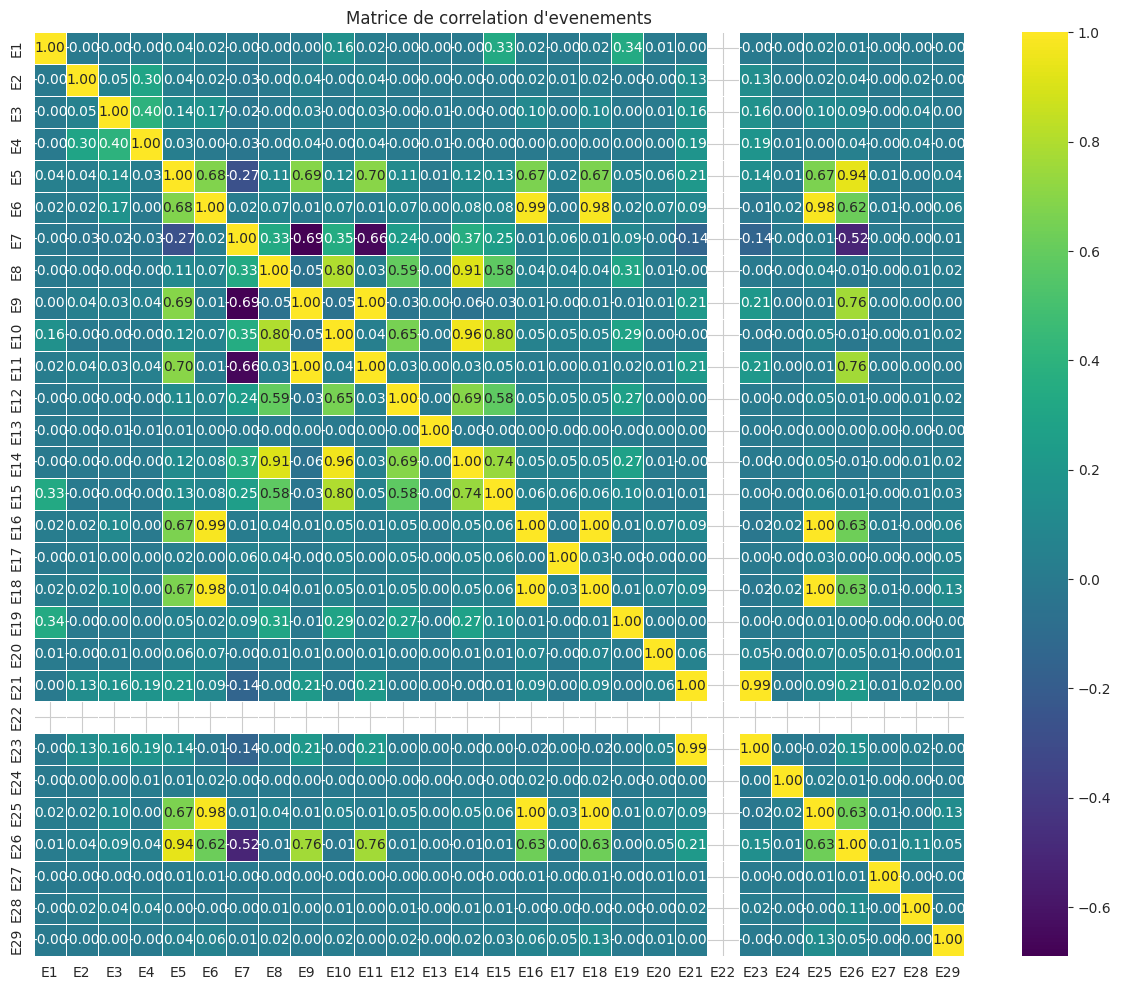


evenement fortement correle:
E16  E18    0.997053
     E25    0.997053
E18  E16    0.997053
E25  E16    0.997053
E11  E9     0.995885
E9   E11    0.995885
E21  E23    0.993810
E23  E21    0.993810
E16  E6     0.985992
E6   E16    0.985992
     E25    0.982934
     E18    0.982934
E25  E6     0.982934
E18  E6     0.982934
E10  E14    0.962083
E14  E10    0.962083
E5   E26    0.939434
E26  E5     0.939434
E14  E8     0.911570
E8   E14    0.911570
dtype: float64


In [10]:
correlation_matrix = X.corr()

# 2. Afficher la Heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='viridis',
    fmt=".2f", # Afficher 2 décimales
    linewidths=.5
)
plt.title('Matrice de correlation d\'evenements')
plt.show()

# 3. Identifier les corrélations très fortes (par exemple, > 0.9)
# Ceci indique une redondance potentielle.
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.9) & (high_corr_pairs < 1.0)]

if not high_corr_pairs.empty:
    print("\nevenement fortement correle:")
    print(high_corr_pairs)